# Using the U-net architecture for human segmentation

**Coursera - Deep Learning with PyTorch: Image segmentation (Guided project)**

### Istall the required dependencies

In [42]:
# Install dependencies
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download dataset from github
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-omg0c1ru
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-omg0c1ru
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done
fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


In [43]:
# Remember to change the runtime to GPU for this project!

# Import libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from tqdm import tqdm
import albumentations as A

import helper

# Append to path:
sys.path.append("/kaggle/working/Human-Segmentation-Dataset-master")

print("Dependencies successfully installed")

Dependencies successfully installed


## Configurations

In [44]:
# CSV_FILE contains the paths to all images and their corresponding masks
CSV_FILE = "/kaggle/working/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/kaggle/working/" # the Human-Segmentation-Dataset-master is on this dir for me
DEVICE = "cuda" # As mentioned before, I'll be using a GPU for this project

### Data exploration

In [45]:
df = pd.read_csv(CSV_FILE)
df.info # Get general information about the data

<bound method DataFrame.info of                                                  masks  \
0    Human-Segmentation-Dataset-master/Ground_Truth...   
1    Human-Segmentation-Dataset-master/Ground_Truth...   
2    Human-Segmentation-Dataset-master/Ground_Truth...   
3    Human-Segmentation-Dataset-master/Ground_Truth...   
4    Human-Segmentation-Dataset-master/Ground_Truth...   
..                                                 ...   
285  Human-Segmentation-Dataset-master/Ground_Truth...   
286  Human-Segmentation-Dataset-master/Ground_Truth...   
287  Human-Segmentation-Dataset-master/Ground_Truth...   
288  Human-Segmentation-Dataset-master/Ground_Truth...   
289  Human-Segmentation-Dataset-master/Ground_Truth...   

                                                images  
0    Human-Segmentation-Dataset-master/Training_Ima...  
1    Human-Segmentation-Dataset-master/Training_Ima...  
2    Human-Segmentation-Dataset-master/Training_Ima...  
3    Human-Segmentation-Dataset-master/Trai

In [46]:
# What the data looks like
df.head(3)

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


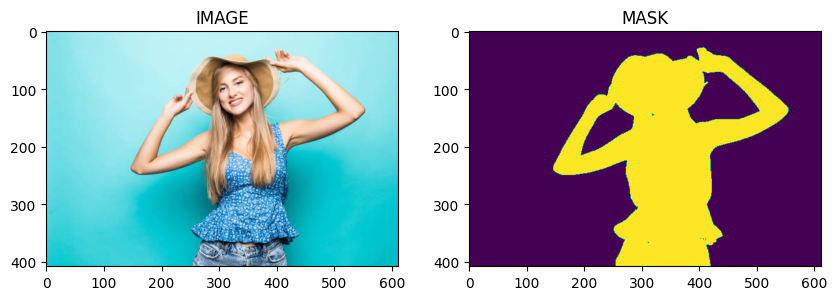

In [47]:
# Load and plot one of the images and the corresponding masks
# Extract paths
row = df.iloc[4]
image_path = row.images
mask_path = row.masks

# Load images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # imges with cv2 are loaded as BGR

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0 # Masks are binary (0, 1 only)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('IMAGE')
ax1.imshow(image)
ax2.set_title('MASK')
ax2.imshow(mask);

## Augmentation Functions

In [48]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE), # Ensures image and mask of the same size
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)

def get_test_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ],is_check_shapes=False)


## Data preparation

In [49]:
train, val = train_test_split(df, test_size=0.2, random_state=42)

### Create custom dataset

In [50]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # rmmbr! images w cv2 are read as bgr

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1) # adding color dimension to the mask (h, w, c)
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
            
        # Transpose mask and image
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0 # rescaling intensity values to be between 0 and 1
        mask = torch.round(torch.Tensor(mask) / 255.0) # We need exactly 0s and 1s
        
        return image, mask

Size of Trainset: 232
Size of Valset: 58


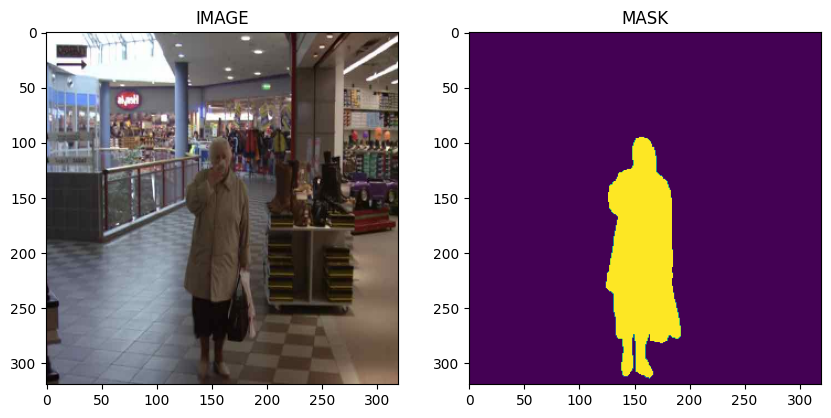

In [51]:
# Training configurations
EPOCHS = 30
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

trainset = SegmentationDataset(train, get_train_augs())
valset = SegmentationDataset(val, get_test_augs())

print(f"Size of Trainset: {len(trainset)}")
print(f"Size of Valset: {len(valset)}")

# Check images are loaded correctly
idx = 8

image, mask = trainset[idx]

image = np.transpose(image, (1, 2, 0))
mask = np.transpose(mask, (1, 2, 0))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('IMAGE')
ax1.imshow(image)
ax2.set_title('MASK')
ax2.imshow(mask);

Total .no of batches in trainLoader: 15
Total .no of batches in valLoader: 4
One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


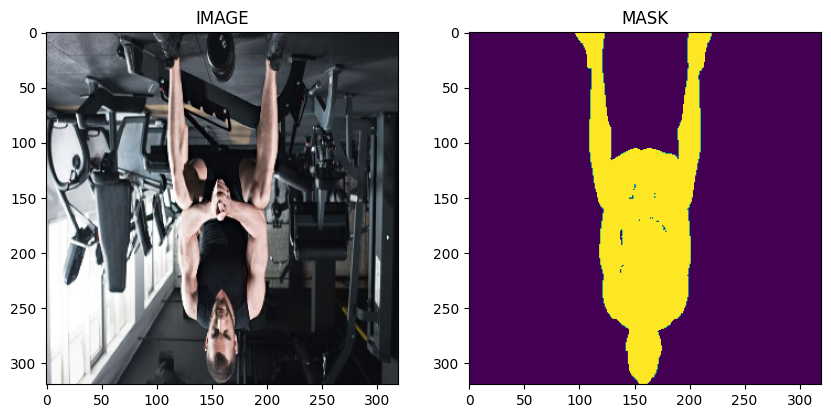

In [52]:
# Load datset into batches
trainLoader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valset, batch_size=BATCH_SIZE)

print(f"Total .no of batches in trainLoader: {len(trainLoader)}")
print(f"Total .no of batches in valLoader: {len(valLoader)}")


# Check shape of a batch
for image, mask in trainLoader:
    break # just aiming to load one batch, not all of them

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

image = np.transpose(image[0], (1, 2, 0)) # remember there is more than 1 ima in the batch
mask = np.transpose(mask[0], (1, 2, 0))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('IMAGE')
ax1.imshow(image)
ax2.set_title('MASK')
ax2.imshow(mask);

## Segmentation Model

In [53]:
# Using segmentations-models-pytorch library and Unet architecture

class SegmentationModel(nn.Module):
    
    def __init__(self):
        # add docstring
        super(SegmentationModel, self).__init__()
        
        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS, # Using pretrained encoder
            in_channels = 3,
            classes = 1,
            activation = None
        )
        
    def forward(self, images, masks=None):
        # add docstring
        logits = self.arc(images)
        
        # When there's a mask, calculate the loss between predicted and gt
        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            
            return logits, loss1 + loss2
        
        # Only when there's no mask to compare to
        return logits
    
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0 # initialization only
    
    # iterate over each batch
    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        # Gradients to 0
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(data_loader) # return mean loss

def eval_fn(data_loader, model):
    
    model.eval()  # You need to set the eval mode so the model is not changed during eval
    total_loss = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()
        
    return total_loss / len(data_loader)

In [54]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

### Model training

In [55]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainLoader, model, optimizer)
    val_loss = eval_fn(valLoader, model)
    
    if val_loss < best_valid_loss:
        torch.save(model.state_dict, 'best_model.pt')
        print("SAVED-MODEL")
        
        best_valid_loss = val_loss
        
    print(f"Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {val_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


SAVED-MODEL
Epoch: 1 Train_loss: 0.7670115411281586 Valid_loss: 1.8988262712955475


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


SAVED-MODEL
Epoch: 2 Train_loss: 0.377350264787674 Valid_loss: 0.5362402722239494


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


SAVED-MODEL
Epoch: 3 Train_loss: 0.3254825552304586 Valid_loss: 0.3037436380982399


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch: 4 Train_loss: 0.28875870207945503 Valid_loss: 0.3139386437833309


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


SAVED-MODEL
Epoch: 5 Train_loss: 0.2944484661022822 Valid_loss: 0.2662499323487282


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch: 6 Train_loss: 0.2359551250934601 Valid_loss: 0.27255209907889366


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


SAVED-MODEL
Epoch: 7 Train_loss: 0.22028953929742176 Valid_loss: 0.19154810532927513


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch: 8 Train_loss: 0.18001003364721935 Valid_loss: 0.20013699308037758


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch: 9 Train_loss: 0.1685461074113846 Valid_loss: 0.24561504274606705


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch: 10 Train_loss: 0.1468321666121483 Valid_loss: 0.26975686103105545


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch: 11 Train_loss: 0.16536117295424144 Valid_loss: 0.20847678929567337


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch: 12 Train_loss: 0.21753588318824768 Valid_loss: 0.681574821472168


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch: 13 Train_loss: 0.21508503158887227 Valid_loss: 0.2236916348338127


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch: 14 Train_loss: 0.1608600750565529 Valid_loss: 0.24520647898316383


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch: 15 Train_loss: 0.18832574983437855 Valid_loss: 0.2313481867313385


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch: 16 Train_loss: 0.14692681630452473 Valid_loss: 0.21700193732976913


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED-MODEL
Epoch: 17 Train_loss: 0.11074796120325724 Valid_loss: 0.18901604413986206


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


SAVED-MODEL
Epoch: 18 Train_loss: 0.1139893760283788 Valid_loss: 0.18766164407134056


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch: 19 Train_loss: 0.10789950092633566 Valid_loss: 0.2093660905957222


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch: 20 Train_loss: 0.159064877529939 Valid_loss: 0.23815268650650978


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch: 21 Train_loss: 0.16837644974390667 Valid_loss: 0.23596052825450897


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch: 22 Train_loss: 0.13633585969607034 Valid_loss: 0.20724551007151604


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch: 23 Train_loss: 0.13207958439985912 Valid_loss: 0.22665124014019966


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch: 24 Train_loss: 0.1403501773873965 Valid_loss: 0.19257082045078278


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


SAVED-MODEL
Epoch: 25 Train_loss: 0.12012736250956853 Valid_loss: 0.16406624019145966


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch: 26 Train_loss: 0.10089767277240753 Valid_loss: 0.16716518253087997


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch: 27 Train_loss: 0.09502929275234541 Valid_loss: 0.1755520049482584


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch: 28 Train_loss: 0.09222434014081955 Valid_loss: 0.18427729979157448


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch: 29 Train_loss: 0.08956721400221189 Valid_loss: 0.21997012570500374


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

Epoch: 30 Train_loss: 0.08847858856121699 Valid_loss: 0.18478436768054962


### Inference

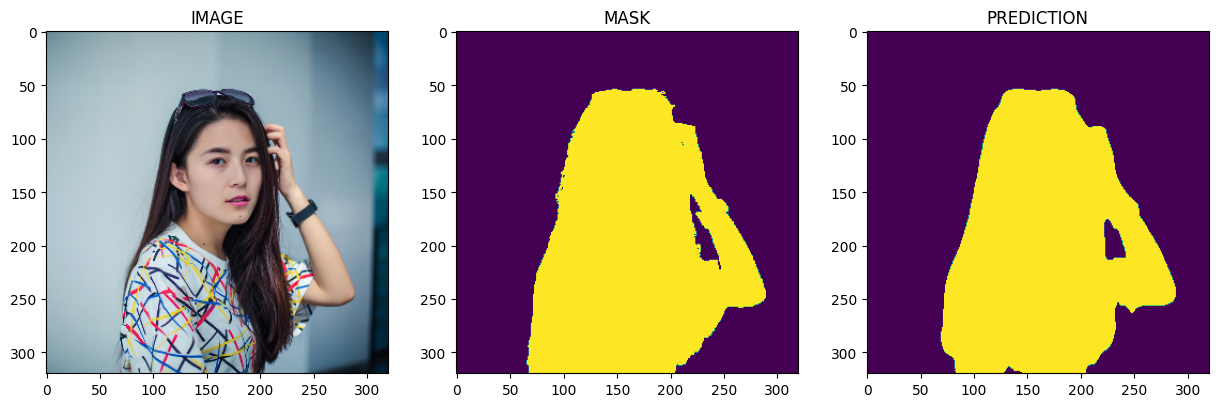

In [57]:
# Using the best model (last model saved) to make the predictions
idx = 11

model = SegmentationModel()
model.to(DEVICE)
model.load_state_dict(torch.load('/kaggle/working/best_model.pt')())

image, mask = valset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # Make it batch like (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0


image = np.transpose(image, (1, 2, 0))
mask = np.transpose(mask, (1, 2, 0))
pred_mask = np.transpose(pred_mask.detach().cpu().squeeze(0), (1, 2, 0))


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.set_title('IMAGE')
ax1.imshow(image)
ax2.set_title('MASK')
ax2.imshow(mask);
ax3.set_title('PREDICTION')
ax3.imshow(pred_mask);